In [2]:
import time
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sentence_transformers.util import cos_sim
from IPython.display import clear_output

import pickle
def save_obj(obj:object,name:str):
    ext = '.pickle'
    with open(name + ext, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(name:str)->object:
    ext = '.pickle'
    with open(name + ext, 'rb') as handle:
        return pickle.load(handle)

In [3]:
def match_keywords(
    keywords_emb:list[np.ndarray],
    candidates_emb : list[np.ndarray],
    thershold: float)\
        -> float:
    """
    match keywords with candidates in a document

    Args:
        keywords_emb (List[np.ndarray]): list of keywords embeddings
        candidates_emb (List[np.ndarray]): list of document's candidates embeddings
        thershold (float): threshold

    Returns:
        float: score
    
    example:
        >>> match_keywords(keywords_emb, candidates_emb, thershold=0.5)
        >>> 0.8
    """
    similarities = list(map(lambda cand:
                    cos_sim(np.array(keywords_emb), cand.reshape(cand.shape[0],cand.shape[1])).__array__().max(axis=1).round(6).clip(-1, 1),
                    candidates_emb))

    return similarities

def grading(keywords_embeddings_list,students_candidates_emb_list,thershold=0.5):
    """
    Args:
        keywords_embeddings_list: list of list of list of embeddings
        students_candidates_emb_list: list of list of list of embeddings
        thershold: thershold for the similarity
    Returns:
        a list of list of list of grades
    """
    grades = []
    for i in range(len(keywords_embeddings_list)):
      grades.append(np.array(list(map(lambda st_cand:
                match_keywords(keywords_embeddings_list[i], st_cand,
                thershold=thershold),
                students_candidates_emb_list[i]
                ))))
    grades = np.array(list(map(lambda sim: (sim.__array__().max(axis=1) >thershold).sum(axis=1)/float(sim.shape[-1]) , grades)))
    return grades

In [6]:
train_path = "data/train_phase1.tsv"
df = pd.read_csv(train_path, sep="\t")
keywords_threshold = 0.53
kwrds_path = 'data/results/keys_score_0.53_essay'
kwrds_res = load_obj(kwrds_path)
siamese_scores = load_obj("data/results/final_siamese_scores")
ner_scores = load_obj("data/results/ner_res")
special_keywords_res = load_obj("data/results/special_keywords_res")

In [9]:
n_df = pd.concat([pd.DataFrame(kwrds_res), pd.DataFrame(siamese_scores[0]), pd.DataFrame(ner_scores[0]),
 pd.DataFrame(special_keywords_res['ess_1_model_answers']),
 pd.DataFrame(df[df['EssaySet'] == 1]['score_gn_1'])],axis=1)
n_df.columns = ['keywords_score', 'siamese_score', 'ner_score', 'special_keywords_score','label']

In [11]:
# train a regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train the model
X = n_df[['keywords_score', 'siamese_score', 'ner_score', 'special_keywords_score']]
y = n_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, model.predict(X_test)))
print("R2:", r2_score(y_test, model.predict(X_test)))

MSE: 0.06554745852240547
R2: 0.444600145849152


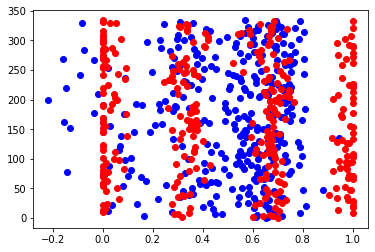

In [12]:
plt.scatter(model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.1219330366030638
R2: -0.03316882564352985


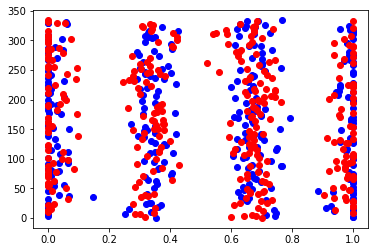

In [13]:
# train the Decision tree model
from sklearn.tree import DecisionTreeRegressor

d_model = DecisionTreeRegressor()
d_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, d_model.predict(X_test)))
print("R2:", r2_score(y_test, d_model.predict(X_test)))
plt.scatter(d_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.07764408973012504
R2: 0.34210239292426114


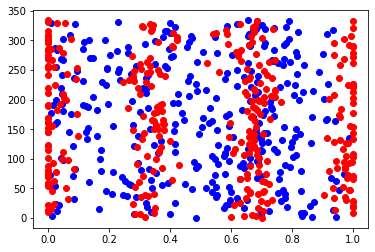

In [14]:
# train the Random forest model
from sklearn.ensemble import RandomForestRegressor

r_model = RandomForestRegressor()
r_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, r_model.predict(X_test)))
print("R2:", r2_score(y_test, r_model.predict(X_test)))

plt.scatter(r_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.0895598198218144
R2: 0.2411374599701791


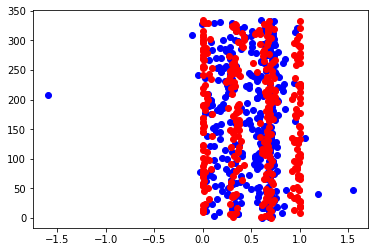

In [84]:
# train gaussian regression model
from sklearn.gaussian_process import GaussianProcessRegressor

g_model = GaussianProcessRegressor()
g_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, g_model.predict(X_test)))
print("R2:", r2_score(y_test, g_model.predict(X_test)))

plt.scatter(g_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.06324852297651669
R2: 0.46407959624542305


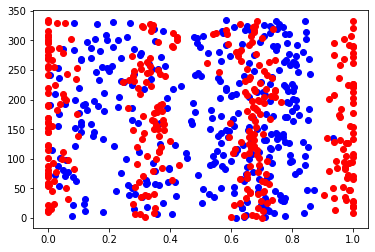

In [85]:
# train the SVR model
from sklearn.svm import SVR

s_model = SVR()
s_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, s_model.predict(X_test)))
print("R2:", r2_score(y_test, s_model.predict(X_test)))

plt.scatter(s_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.0638052803325186
R2: 0.459362053242361


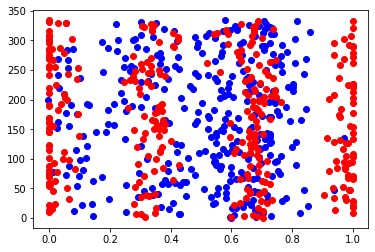

In [86]:
# train the MLP model
from sklearn.neural_network import MLPRegressor

m_model = MLPRegressor()
m_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, m_model.predict(X_test)))
print("R2:", r2_score(y_test, m_model.predict(X_test)))

plt.scatter(m_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');

MSE: 0.08108911282317098
R2: 0.3129118588203341


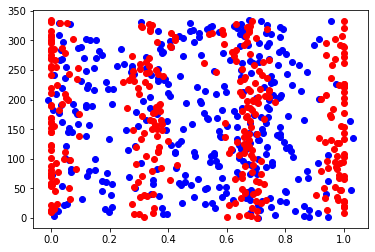

In [87]:
# train the xgboost model
from xgboost import XGBRegressor

x_model = XGBRegressor()
x_model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, x_model.predict(X_test)))
print("R2:", r2_score(y_test, x_model.predict(X_test)))

plt.scatter(x_model.predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');